============================================================================

Supervised Implementation :

source : https://gist.github.com/mbacvanski/07526e86dee5bf6ba2d09e55e4a14902

=============================================================================

In [ ]:
import torch
import numpy as np
from typing import List
from tqdm import tqdm

    
    آ) لودکردن دیتاست


In [ ]:
#load the data set and fill nan value with 0
# TODO (load dataset)
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



# convert 28*28 to 1*784
x_train_vector = x_train.reshape(x_train.shape[0], 1, 784)

x_train_vector.shape

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


(60000, 1, 784)


ب)   تولید داده  


In [ ]:
def combine_x_y(x, y):
    """
    The forward-forward network expects inputs to contain both the input data (x) as well as the label (y). This method
    concatenates the data and label together. Note there are 10 possible classes.
    """
    x_ = x.clone()
    label_onehot = torch.nn.functional.one_hot(y, 10) * x.max()
    return torch.hstack([x, label_onehot])

ج) پیاده سازی شبکه

In [ ]:
class Layer(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)

        # define the components we will use
        self.activation = torch.nn.ReLU()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.03)

        # define hyperparameters
        self.threshold = 2.0
        self.num_epochs = 1000

        # keep track of losses during training
        self.losses = []

    def forward(self, x):
        """
        Here we define the forward pass through this layer. This is the same as how a linear layer does it,
        taking the matrix multiplication of x^T and the weights and adding the bias term. The difference is that
        here we integrate normalization into the layer, so we first take only the unit vector of the input.

        Remember that because the previous layer will be outputting a vector of differing magnitude depending on how
        'excited' it is about its input, taking the norm of the vector guarantees that only the information about
        direction of the output vector from the previous layer is used to determine how excited this layer is about
        the input.
        """
        x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-8)
        # w^T + b
        return self.activation(
            torch.mm(x_normalized, self.weight.T) + self.bias.unsqueeze(0)
        )

    def train(self, x_positive, x_negative):
        """
        Each layer of the forward-forward network can train itself, because it does not rely on gradients from other
        layers in the network. All it needs is a source of positive and negative data. The first layer of the network
        receives data as the concatenation of X and Y (data and label), while subsequent layers receive the output
        of the previous layer's forward pass on the positive and negative data respectfully.
        """
        self.losses = []
        for i in tqdm(range(self.num_epochs)):
            goodness_positive = self.forward(x_positive).pow(2).mean(1)
            goodness_negative = self.forward(x_negative).pow(2).mean(1)

            """
            We define our loss function so that if we were to minimize it, we would end up having to maximize
            the goodness of the x_positive, and minimize the goodness of x_negative. This cost function provides
            the surface for which we find the gradient to minimize. This could take the form of
            goodness_negative / goodness_positive. Exponentiating this fraction increases the
            """
            loss = torch.log(1 + torch.exp(torch.cat([
                -goodness_positive + self.threshold,
                goodness_negative - self.threshold]))).mean()

            """
            Notice that even though we use the gradient, this gradient is only locally computed within this layer.
            """
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.losses.append(loss.item())

        """
        The goodness computed in this layer's forward pass is needed to train the next layer. This is what the next
        layer will use as its x_positive and x_negative.
        """
        return self.forward(x_positive).detach(), self.forward(x_negative).detach()

In [ ]:
class FFNN(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers: List[Layer] = []

        for d in range(len(dims) - 1):
            self.layers.append(Layer(dims[d], dims[d+1]).cuda())

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            """ Generate an array of just that label, since we want to append that label to all x """
            label_arr = [label] * x.shape[0]
            input = combine_x_y(x, torch.tensor(label_arr).cuda())

            """ Run this input through the network and record the total activation across the whole network """
            goodnesses_per_layer = self._forward_pass(input)
            goodness_per_label.append(sum(goodnesses_per_layer).unsqueeze(1))

        """ The class predicted is the class of data that achieves the highest activation. With X staying constant,
        the only difference comes from the label appended to X. """
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_positive, x_negative):
        """ Use the activations from the previous layer for the positive and negative data, respectfully, to train the
        subsequent layers. """
        h_positive, h_negative = x_positive, x_negative
        for i, layer in enumerate(self.layers):
            print('Training layer', i)
            h_positive, h_negative = layer.train(h_positive, h_negative)

    def get_losses(self):
        return [l.losses for l in self.layers]

    def _forward_pass(self, input):
        h = input
        goodnesses = []
        for layer in self.layers:
            """ Goodness is computed as the magnitude of the activations of this layer """
            activation = layer(h)
            activation_magnitude = activation.pow(2).mean(1)
            goodnesses.append(activation_magnitude)

            """ Use the activation of this layer as the input to the next layer """
            h = activation

        return goodnesses

د) گزارش نتایج

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import MNIST

def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


In [ ]:
torch.manual_seed(42)
train_loader, test_loader = MNIST_loaders()

In [ ]:
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()

x_positive = combine_x_y(x, y)
x_positive

tensor([[-0.4242, -0.4242, -0.4242,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4242, -0.4242, -0.4242,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4242, -0.4242, -0.4242,  ...,  0.0000,  2.8215,  0.0000],
        ...,
        [-0.4242, -0.4242, -0.4242,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4242, -0.4242, -0.4242,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4242, -0.4242, -0.4242,  ...,  2.8215,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
""" Let's make a network with 2 layers of 500 neurons each. """
input_dimension = x_positive[0].size(0)
network = FFNN([input_dimension, 500, 500])

In [ ]:
""" We can generate simple negative data by simply combining the images with random labels. """
rnd = torch.randperm(y.size(0))
x_negative = combine_x_y(x, y[rnd])

network.train(x_positive, x_negative)

print('Training error:', 1.0 - network.predict(x).eq(y).float().mean().item())

Training layer 0


100%|██████████| 1000/1000 [01:01<00:00, 16.14it/s]


Training layer 1


100%|██████████| 1000/1000 [00:39<00:00, 25.24it/s]


Training error: 0.0715399980545044


In [ ]:
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

print('Test error:', 1.0 - network.predict(x_test).eq(y_test).float().mean().item())

Test error: 0.07090002298355103


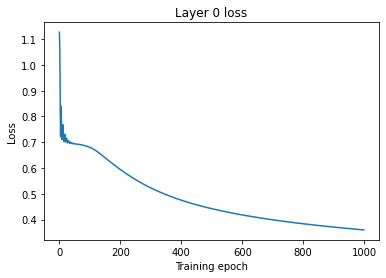

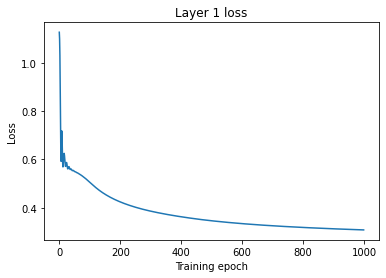

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss: List[float], title):
    plt.plot(range(len(loss)), loss)
    plt.title(title)
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')

losses = network.get_losses()
plot_loss(losses[0], 'Layer 0 loss')
plt.show()
plot_loss(losses[1], 'Layer 1 loss')
plt.show()


=============================================================================


Unsupervized Implementation :

source : https://github.com/ghadialhajj/FF_unsupervised/blob/master/README.md


==============================================================================

In [3]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import prepare_data
from sklearn.metrics import accuracy_score

In [4]:
def goodness_score(pos_acts, neg_acts, threshold=2):
    """
    Compute the goodness score for a given set of positive and negative activations.

    Parameters:

    pos_acts (torch.Tensor): Numpy array of positive activations.
    neg_acts (torch.Tensor): Numpy array of negative activations.
    threshold (int, optional): Threshold value used to compute the score. Default is 2.

    Returns:

    goodness (torch.Tensor): Goodness score computed as the sum of positive and negative goodness values. Note that this
    score is actually the quantity that is optimized and not the goodness itself. The goodness itself is the same
    quantity but without the threshold subtraction
    """

    pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
    neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
    return torch.add(pos_goodness, neg_goodness)


def get_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return dict(accuracy_score=acc)

In [5]:
class FF_Layer(nn.Linear):
    def __init__(self, in_features: int, out_features: int, n_epochs: int, bias: bool, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.parameters())
        self.goodness = goodness_score
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)

    def ff_train(self, pos_acts, neg_acts):
        """
        Train the layer using positive and negative activations.

        Parameters:

        pos_acts (numpy.ndarray): Numpy array of positive activations.
        neg_acts (numpy.ndarray): Numpy array of negative activations.
        """

        self.opt.zero_grad()
        goodness = self.goodness(pos_acts, neg_acts)
        goodness.backward()
        self.opt.step()

    def forward(self, input):
        input = super().forward(input)
        input = self.ln_layer(input.detach())
        return input

In [6]:
class Unsupervised_FF(nn.Module):
    def __init__(self, n_layers: int = 4, n_neurons=2000, input_size: int = 28 * 28, n_epochs: int = 100,
                 bias: bool = True, n_classes: int = 10, n_hid_to_log: int = 3, device=torch.device("cuda:0")):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs = n_epochs
        self.device = device

        ff_layers = [
            FF_Layer(in_features=input_size if idx == 0 else n_neurons,
                     out_features=n_neurons,
                     n_epochs=n_epochs,
                     bias=bias,
                     device=device) for idx in range(n_layers)]

        self.ff_layers = ff_layers
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.to(device)
        self.opt = torch.optim.Adam(self.last_layer.parameters())
        self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training FF Layers", position=0)
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(pos_dataloader, neg_dataloader), desc=f"Training FF Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_imgs in inner_tqdm:
                pos_imgs, _ = pos_data
                pos_acts = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)

                for idx, layer in enumerate(self.ff_layers):
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.ff_train(pos_acts, neg_acts)

    def train_last_layer(self, dataloader: DataLoader):
        num_examples = len(dataloader)
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training Last Layer", position=0)
        loss_list = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds = self(images)
                loss = self.loss(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            loss_list.append(epoch_loss / num_examples)
            # Update progress bar with current loss
        return [l.detach().cpu().numpy() for l in loss_list]

    def forward(self, image: torch.Tensor):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader: DataLoader, dataset_type: str = "train"):
        self.eval()
        inner_tqdm = tqdm(dataloader, desc=f"Evaluating model", leave=False, position=1)
        all_labels = []
        all_preds = []
        for images, labels in inner_tqdm:
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self(images)
            preds = torch.argmax(preds, 1)
            all_labels.append(labels.detach().cpu())
            all_preds.append(preds.detach().cpu())
        all_labels = torch.concat(all_labels, 0).numpy()
        all_preds = torch.concat(all_preds, 0).numpy()
        metrics_dict = get_metrics(all_preds, all_labels)
        print(f"{dataset_type} dataset scores: ", "\n".join([f"{key}: {value}" for key, value in metrics_dict.items()]))


def train(model: Unsupervised_FF, pos_dataloader: DataLoader, neg_dataloader: DataLoader):
    model.train()
    model.train_ff_layers(pos_dataloader, neg_dataloader)
    return model.train_last_layer(pos_dataloader)

In [ ]:
def plot_loss(loss):
    # plot the loss over epochs
    fig = plt.figure()
    plt.plot(list(range(len(loss))), loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.savefig("Loss Plot.png")
    plt.show()


if __name__ == '__main__':
    prepare_data()

    # Load the MNIST dataset
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
    # pos_dataset = Subset(pos_dataset, list(range(1000)))
    # Create the data loader
    pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

    # Load the transformed images
    neg_dataset = torch.load('transformed_dataset.pt')
    # Create the data loader
    neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

    # Load the test images
    test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
    # Create the data loader
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

    device = torch.device("cuda:0")
    unsupervised_ff = Unsupervised_FF(device=device, n_epochs=2)

    loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

    plot_loss(loss)

    unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
    unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")